In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate , train_test_split , StratifiedShuffleSplit
from sklearn import   linear_model, metrics
from sklearn.linear_model import SGDClassifier as SGD
import seaborn as sns

In [2]:
train_directory = "train.csv"

train = pd.read_csv(train_directory, header=0 )

train['y'] = [1 if y == 'yes' else 0 for y in train['y']]

# Классификация

In [3]:
X = train[['age' , 'previous']][:]
y = train['y'][:]

In [4]:
classifier = RandomForestClassifier()

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

In [6]:
classifier.fit(train_data , train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
pred_labels = classifier.predict(test_data)

In [8]:
metrics.roc_auc_score(test_labels, pred_labels)

0.5460532618066865

# 1. Выводы по существующим данным и исходной модели

В случае исходной модели обрабатывается только один признак - количество предыдущих платежей. Для большого количества данных одного признака недостаточно, поэтому и была получена плохая оценка качества модели ~0,5, что говорит о том, что модель предсказывает по методу "пальцем в небо". Сначала необходимо добавить больше признаков для нашей модели. 

Всего в сете 20 признаков + таргет, поэтому есть где разгуляться и добавить новые признаки

In [9]:
train.shape
print('Имеющиеся признаки: ', '; '.join(list(train)))
print('Наличие null ', train.isnull().values.any())
print('Наличие пустых значений ', train.isna().values.any())
train.head()

Имеющиеся признаки:  age; job; marital; education; default; housing; loan; contact; month; day_of_week; duration; campaign; pdays; previous; poutcome; emp.var.rate; cons.price.idx; cons.conf.idx; euribor3m; nr.employed; y
Наличие null  False
Наличие пустых значений  False


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,0
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,0
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,0


# 2. Подготовка данных
Многие признаки имеют нечисловые значения, которые не могут обрабатываться. Поэтому нужно перевести их в числа

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             3222 non-null   int64  
 1   job             3222 non-null   object 
 2   marital         3222 non-null   object 
 3   education       3222 non-null   object 
 4   default         3222 non-null   object 
 5   housing         3222 non-null   object 
 6   loan            3222 non-null   object 
 7   contact         3222 non-null   object 
 8   month           3222 non-null   object 
 9   day_of_week     3222 non-null   object 
 10  duration        3222 non-null   int64  
 11  campaign        3222 non-null   int64  
 12  pdays           3222 non-null   int64  
 13  previous        3222 non-null   int64  
 14  poutcome        3222 non-null   object 
 15  emp.var.rate    3222 non-null   float64
 16  cons.price.idx  3222 non-null   float64
 17  cons.conf.idx   3222 non-null   f

In [11]:
for feature in list(train):
    values = set(train[feature])
    print(feature.upper(), ':', values)
    print()


AGE : {18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 85, 86, 88}

JOB : {'technician', 'retired', 'admin.', 'blue-collar', 'unemployed', 'services', 'self-employed', 'unknown', 'student', 'entrepreneur', 'housemaid', 'management'}

MARITAL : {'divorced', 'single', 'married', 'unknown'}

EDUCATION : {'high.school', 'basic.4y', 'basic.9y', 'basic.6y', 'unknown', 'university.degree', 'professional.course'}

DEFAULT : {'no', 'unknown'}

HOUSING : {'no', 'yes', 'unknown'}

LOAN : {'no', 'yes', 'unknown'}

CONTACT : {'telephone', 'cellular'}

MONTH : {'aug', 'jun', 'sep', 'mar', 'apr', 'oct', 'nov', 'dec', 'may', 'jul'}

DAY_OF_WEEK : {'fri', 'thu', 'wed', 'mon', 'tue'}

DURATION : {0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,

## Обработка категориальных признаков

Конечное множество строковых значений принимают фичи: job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome. 

Пронумеруем все значения в множестве и заменим на порядковый номер все значения. За 0 примем во всех фичах значение 'unknown'

In [12]:
# замена 'job'
job_values = ['technician', 'services', 'self-employed',
              'admin.', 'retired', 'management', 
              'blue-collar', 'housemaid', 'unemployed',
              'student', 'entrepreneur', 'unknown']

job_numbers = [1, 2, 3,
              4, 5, 6,
              7, 8, 9,
              10, 11, 0]

train['job'] = train['job'].replace(job_values, job_numbers)

# замена 'marital'
marital_values = ['unknown', 'married', 'single', 'divorced']
marital_numbers = [0, 1, 2, 3]

train['marital'] = train['marital'].replace(marital_values, marital_numbers)

# замена 'education'
edu_values = ['basic.4y', 'basic.6y', 'basic.9y',
              'high.school',  'professional.course', 'university.degree', 'unknown']
edu_numbers = [1, 2, 3, 4, 5, 6, 0]

train['education'] = train['education'].replace(edu_values, edu_numbers)

# замена 'default'
default_values = ['no', 'unknown']
default_numbers = [1, 0]

train['default'] = train['default'].replace(default_values, default_numbers)

# замена 'housing'
house_values = ['no', 'yes', 'unknown']
house_numbers = [1, 2, 0]

train['housing'] = train['housing'].replace(house_values, house_numbers)

# замена 'loan'
loan_values = ['no', 'yes', 'unknown']
loan_numbers = [1, 2, 0]

train['loan'] = train['loan'].replace(loan_values, loan_numbers)

# замена 'contact'
contact_values = ['cellular', 'telephone']
contact_numbers = [1, 2]

train['contact'] = train['contact'].replace(contact_values, contact_numbers)

# замена 'month'
# возьмем все месяцы, даже если их нет в выборке
month_values = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

train['month'] = train['month'].replace(month_values, month_numbers)

# замена 'day_of_week'
# возьмем все дни, даже если их нет в выборке
day_values = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
day_numbers = [1, 2, 3, 4, 5, 6, 7]

train['day_of_week'] = train['day_of_week'].replace(day_values, day_numbers)

# замена 'poutcome'
outcome_values = ['success', 'nonexistent', 'failure']
outcome_numbers = [1, 0, -1]

train['poutcome'] = train['poutcome'].replace(outcome_values, outcome_numbers)

train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,7,1,3,1,2,1,1,5,5,...,2,999,0,0,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,2,2,4,1,1,1,2,5,5,...,4,999,0,0,1.1,93.994,-36.4,4.855,5191.0,0
2,25,2,1,4,1,2,1,2,6,3,...,1,999,0,0,1.4,94.465,-41.8,4.962,5228.1,0
3,38,2,1,3,1,0,0,2,6,5,...,3,999,0,0,1.4,94.465,-41.8,4.959,5228.1,0
4,47,4,1,6,1,2,1,1,11,1,...,1,999,0,0,-0.1,93.200,-42.0,4.191,5195.8,0


Плохо, что нет описания признаков, потому что мне кажется, что pdays это категориальный признак, а может он и вещественный... В общем, полагая что это категориальный признак, я просто поменяю 999 на 8

In [13]:
train['pdays'] = train['pdays'].replace(999, 8)
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,7,1,3,1,2,1,1,5,5,...,2,8,0,0,-1.8,92.893,-46.2,1.313,5099.1,0
1,39,2,2,4,1,1,1,2,5,5,...,4,8,0,0,1.1,93.994,-36.4,4.855,5191.0,0
2,25,2,1,4,1,2,1,2,6,3,...,1,8,0,0,1.4,94.465,-41.8,4.962,5228.1,0
3,38,2,1,3,1,0,0,2,6,5,...,3,8,0,0,1.4,94.465,-41.8,4.959,5228.1,0
4,47,4,1,6,1,2,1,1,11,1,...,1,8,0,0,-0.1,93.200,-42.0,4.191,5195.8,0


## Масштабирование вещественных признаков

In [14]:
for f in ['age', 'duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']:
    max_value = train[f].max()
    train[f] = list(x/max_value for x in train[f])
    
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.340909,7,1,3,1,2,1,1,5,5,...,2,8,0,0,-1.285714,0.980225,1.717472,0.260258,0.975326,0
1,0.443182,2,2,4,1,1,1,2,5,5,...,4,8,0,0,0.785714,0.991843,1.353160,0.962339,0.992904,0
2,0.284091,2,1,4,1,2,1,2,6,3,...,1,8,0,0,1.000000,0.996813,1.553903,0.983548,1.000000,0
3,0.431818,2,1,3,1,0,0,2,6,5,...,3,8,0,0,1.000000,0.996813,1.553903,0.982953,1.000000,0
4,0.534091,4,1,6,1,2,1,1,11,1,...,1,8,0,0,-0.071429,0.983465,1.561338,0.830723,0.993822,0


# 3. Попытки улучшить модель
## 3.1. Методом "в лоб"
Возьмем все имеющиеся признаки (почему бы и нет, если их количество не сильно велико), а затем будем постепенно их удалять и наблюдать за изменением качества модели 

In [15]:
X = train[:][:]
X = X.drop(['y'], axis=1)
y = train['y'][:]

In [16]:
classifier = RandomForestClassifier()

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

classifier.fit(train_data , train_labels)

pred_labels = classifier.predict(test_data)

metrics.roc_auc_score(test_labels, pred_labels)

0.6778650378126818

In [17]:
classifier = RandomForestClassifier()

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

scores_rf = cross_validate(classifier, X, y, scoring='roc_auc', cv=sss)

scores_rf['test_score'].mean()

0.928709822287804

In [18]:
sgd = SGD(max_iter=1000, tol=1e-3)

scores_sgd = cross_validate(sgd, X, y, scoring='roc_auc', cv=sss)
scores_sgd['test_score'].mean()

0.8727208571245268

## 3.2. Удаление взаимозависимых признаков

In [19]:
features = train.copy()

features.drop(['y'], axis='columns', inplace=True)

<AxesSubplot:>

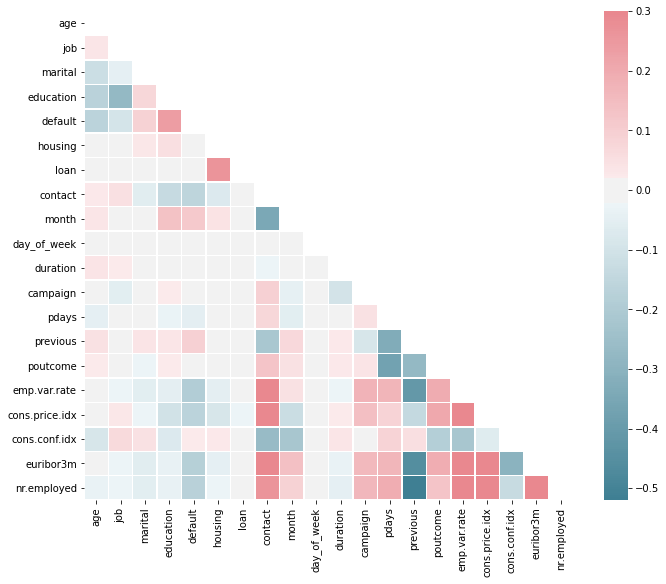

In [20]:
corr = features.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

In [21]:
for f1 in list(features):
    print(f1)
    print(corr[abs(corr[f1]) >= 0.8].index)

age
Index(['age'], dtype='object')
job
Index(['job'], dtype='object')
marital
Index(['marital'], dtype='object')
education
Index(['education'], dtype='object')
default
Index(['default'], dtype='object')
housing
Index(['housing'], dtype='object')
loan
Index(['loan'], dtype='object')
contact
Index(['contact'], dtype='object')
month
Index(['month'], dtype='object')
day_of_week
Index(['day_of_week'], dtype='object')
duration
Index(['duration'], dtype='object')
campaign
Index(['campaign'], dtype='object')
pdays
Index(['pdays'], dtype='object')
previous
Index(['previous'], dtype='object')
poutcome
Index(['poutcome'], dtype='object')
emp.var.rate
Index(['emp.var.rate', 'euribor3m', 'nr.employed'], dtype='object')
cons.price.idx
Index(['cons.price.idx'], dtype='object')
cons.conf.idx
Index(['cons.conf.idx'], dtype='object')
euribor3m
Index(['emp.var.rate', 'euribor3m', 'nr.employed'], dtype='object')
nr.employed
Index(['emp.var.rate', 'euribor3m', 'nr.employed'], dtype='object')


Получились следующие пары зависимых признаков:
1. emp.var.rate - euribor3m
2. emp.var.rate - nr.employed
3. nr.employed - euribor3m
В уелом, эти три признака можно заменить одним. Оставляю nr.employed

In [22]:
X = train[:][:]
X = X.drop(['y', 'emp.var.rate', 'euribor3m'], axis=1)
y = train['y'][:]

In [23]:
classifier = RandomForestClassifier()

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2)

classifier.fit(train_data , train_labels)

pred_labels = classifier.predict(test_data)

metrics.roc_auc_score(test_labels, pred_labels)

0.6549084110380082

In [24]:
classifier = RandomForestClassifier()

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

scores_rf = cross_validate(classifier, X, y, scoring='roc_auc', cv=sss)

scores_rf['test_score'].mean()

0.9294230234597208

In [25]:
sgd = SGD(max_iter=1000, tol=1e-3)

scores_sgd = cross_validate(sgd, X, y, scoring='roc_auc', cv=sss)
scores_sgd['test_score'].mean()

0.8416565086289858

## 3.3. Проверка зависимости таргета от признака
Определим влияние признака на значение целевого параметра

In [26]:
corr_values = {}
for feature in features:      
    corr_values[feature] = train['y'].corr(train[feature])
corr_values

{'age': 0.053425164262011354,
 'job': -0.012879199934497217,
 'marital': 0.03165707813514039,
 'education': 0.03340414179979276,
 'default': 0.068976692774852,
 'housing': -0.0014047410997329165,
 'loan': -0.0015503286842527986,
 'contact': -0.13252912295426397,
 'month': 0.03980724795631547,
 'day_of_week': -0.015079539991408026,
 'duration': 0.4335956815283215,
 'campaign': -0.07992847286607391,
 'pdays': -0.20207889124217843,
 'previous': 0.26813414555523374,
 'poutcome': 0.1259785338901153,
 'emp.var.rate': -0.25983405901595324,
 'cons.price.idx': -0.0657743125980148,
 'cons.conf.idx': -0.03476802141162715,
 'euribor3m': -0.2783752173082435,
 'nr.employed': -0.33228094499135585}

Зависимых (линейно) признаков нет, поэтому эту идею пришлось оставить

# 4. Итог

В результате были получены показатели roc-auc на тесте 0,73 (лучшее)

Если бы было больше времени, то первым делом, я бы попробовала определить что именно означает каждый признак. Далее можно было бы попробовать определить нелинейные зависимости между таргетом и признаком, поскольку используемый метод определения значимости показывал только линейную зависимость. Можно было бы поиграть с количеством деревьев в RandomForest, поиграть с количеством факторов: прямо построить графики, как меняется ошибка в зависимости от количества деревьев и факторов. Попробовать другие методы определения значимых факторов (гугл в помощь)